# MCMC Python Notebook

This notebook was designed to teach the basics of Markov-Chain-Monte-Carlo.

Bayes Theorem:  

$$p(x~|~d) = \frac{p(x)~p(d~|~x)}{p(d)}$$

With:  

$x$ - model parameters  
$d$ - data  
$p(x~|~d) = \mathcal{P}$ - posterior  
$p(x) = \pi$ - prior  
$p(d~|~x) = \mathcal{L}$ - likelihood  
$p(d) = \mathcal{Z}$ - evidence  

The evidence, $\mathcal{Z}$, is important for Baysian model comparison.  For MCMC we are only interested in the posterior, $\mathcal{P}$, so we ignore the normalization.  We can get away without normalization as MCMC does relative comparisions of the $\mathcal{P}$ for different values of $x$.  Thus we have,

$$ \mathcal{P} \propto \pi~ \mathcal{L} $$

Let's adopt a likelihood function that uses independent Gaussians as uncertainties:

$$\mathcal{L} = \prod_k \frac{1}{(2\pi)^{1/2} \sigma_k} exp\left[-\frac{1}{2}\frac{(f(x_k)-d_k)^2}{\sigma_k^2} \right] $$

or as a log,

$$ \log\mathcal{L} = \frac{1}{2}\sum_k -\log(pi) -\log(\sigma_k^2) -\frac{(f(x_k)-d_k)^2}{\sigma_k^2} $$
$$ \left( Notice: \log\mathcal{L} = -\frac{1}{2}\chi^2 + C \right) $$

With:

$f$ - our model that depends on $x$  
$\sigma$ - independent measurement error  

We did not need to assume independent Gaussian errors, but let's keep this tutorial simple.

We will adopt a Gaussian as our function:

$$ f(x) = a~exp \left[ \frac{-(x-b)}{2~c^2} \right] + z$$

We will consider and implement uniform priors.



In [1]:
#import modules and enable inline plots
import numpy as np
import matplotlib  #ploting
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Define our model f(x) 

In [2]:
def gaussian(*xin,a,b,c,z):
    "Gaussian Function a=amp,b=center,c=width"
    lx=list(xin)                                           #convert from tuple to list
    g=[]                                                   #initialize output
    for x in lx:
        g.append(a*np.exp(-np.power(x-b,2.0)/(2.0*c*c))+z) #Gaussian Function
    g=np.array(g[0])                                       #convert to array
    return g;

## Generating some fake data with Gaussian scatter

In [3]:
t=np.array(range(0,100))*0.1         #our independent variable, with 100 samples 

a=1.0;b=5.0;c=1.0;z=0.0;             #parameters for a our Gaussian model.

g=gaussian(t,a=a,b=b,c=c,z=z)        #generate a Gaussian for each t

sig=0.2                              #How much noise to add

d=g+np.random.normal(0.0,sig,len(g)) #add in some Gaussian Noise
                                     #The array d now defines our data set (measurements)

derr=np.ones(len(d))*sig             #assign uncertainties to our data

## Plot our fake data

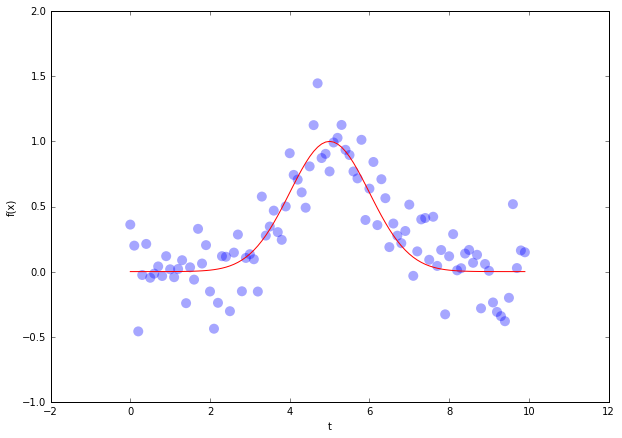

In [4]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
plt.plot(t,g,c='red')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.35, edgecolors="none")
plt.show()

## Estimate the posterior, $\mathcal{P}$, on model parameters $x={a,b,c,z}$ given our data $d$

We will be using Markov-Chain-Monte-Carlo, first we define our Likeihood function

In [5]:
def loglikelihood(func,pars,t,data,derr):
    "Returns the log-likelihood for independent Gaussians"
    m=func(t,a=pars[0],b=pars[1],c=pars[2],z=pars[3]) #get model
    n=len(data)
    #add in functionality to scale errors
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
    ll=-n*np.log(2*np.pi)-sum(derr*derr*dscale*dscale)-sum((m-data)*(m-data)/(derr*derr*dscale*dscale))
    
    return ll;

and we define our Priors:

In [6]:
def lprior(pars):
    "Simple prior with log(pr)=0 with valid parameters, otherwise return large small value"
    a=pars[0];b=pars[1];c=pars[2];z=pars[3];
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
    badlpr=-1.0e30    #bad lpr value
    lpr=0.0           #default return value
    if a > 5:
        lpr=badlpr
    if a < -5:
        lpr=badlpr
    if b > 10:
        lpr=badlpr
    if b < 0:
        lpr=badlpr
    if c > 10:
        lpr=badlpr
    if c < 0:
        lpr=badlpr
    #no prior on z.
    if dscale < 0:
        lpr=badlpr
    
    return lpr;

# Markov Chain Monte Carlo, the Metropolis-Hastings Algorithm, and the Gibbs Sampler

Excerpts from From Ford, E. 2005 AJ 129, 1706:

> Bayesian inference using Markov chain Monte Carlo (MCMC) simulations provides a method for estimating the uncertainty of fitted parameters.  

In the next section f(x) refers to the posterior distribution $p(x~|~d)$

>The goal of the MCMC method is to generate a chain (i.e., sequence) of states (i.e., sets of parameter values $x_i$) that are sampled from a desired probability distribution [$f(x)$]. Such a chain can be calculated by specifying an initial set of parameter values, $x_0$, and a transition probability, $p(x_{n+1}|x_n)$. The Monte Carlo aspect of MCMC simulation refers to randomness in the generation of each subsequent state. The Markov property specifies that the probability distribution for determination of $x_{n+1}$ can depend on xn but not previous states. If the Markov chain is reversible, that is, if 

> $$ f(x)p(x~|~x') = f(x')p(x'~|~x) $$

>and it is aperiodic and irreducible, then it can be proved that the Markov chain will eventually converge to the stationary distribution $f(x)$ (Gilks et al. 1995). The requirement that the chain be irreducible guarantees that it will be possible for the chain to reach every state with nonzero probability from any initial state.

A Markov-Chain refers to sets of model parameters which are generated by selecting a trail parameter set and using the relative probabilities to randomly select or reject the trail set.  To show this works we will use the Metropolis-Hasting (M-H) algorithm and walk through the algorthim.

(adopted from Ford 2005) :  
 1) Initilize the chain with $n=1$, $x_n=x_0$ (current state)  
 2) Generate a trial state ($x'$) with an appropriate transition function $q(x'~|~x_n)$  
 3) Calculate the Likelihood for the trial and Likelihood for the transition state  
 4) Determine the acceptance probability $\alpha(x'|x)$  
 5) Draw a random number $u$=[0,1]  
 6) If $u \leq \alpha(x'~|~x)$ then $x_{n+1} = x'$ else $x_{n+1} = x_n$  
 7) n=n+1  
 8) GOTO step 2  
 
The acceptance probability for the M-H algorithm is,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)~q(x~|~x')}{p(x'~|~d)~q(x'~|~x)},~1   \right]$$

We will use a Gibbs sampler as our choice for $q(x~|~x')$,

$$ q(x'_{\mu}|x_{\mu}) = \frac{1}{\sqrt{2\pi\beta^2_{\mu}}} exp \left[ -\frac{(x'_{\mu}-x_{\mu})^2}{2\beta^2_{\mu}} \right] $$

Rather than trying to alter all components of $x$ and estimating the transition probabilities $q$ over a multi-dimensional space, the Gibbs sampler operations on one variable at a time.  The adoption of a Gaussian as our transition function means that $q(x'~|~x)=q(x~|~x)$ which reduces the M-H acceptance probability to,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)}{p(x'~|~d)},~1   \right]$$.

In step(2) from our M-H recipe we now randomly select one component of $x$ to change at a time.  The Gibbs sample has tunable parameters $\beta_{\mu}$ for each parameter.  The choice of $\beta$ determines much to change a parameter value in each new state.  If $\beta$ is too large, then acceptance of new states will be low.  If $\beta$ is too small then acceptance will be too high.  In both cases, the M-H algorithm will be very slow towards reaching convergence and estimating $p(x~|~d)$.  

## Let's implement the M-H algorithm with a Gibb's sampler.

In [7]:
def mhmcmc(x,llx,beta,t,d,derr):
    "A Metropolis-Hastings MCMC sampler"
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(gaussian,xt,t,d,derr) #Step 3 Compute log(p(x'|d))
    llxt=llxt+lprior(xt) 
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                             #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                             #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

## Let's use our M-H MCMC algorithm and generate 50 000 chains.

In [8]:
def genchain(x,beta,niter):
    "Generate Markov Chain"
    chain=[]                                  #Initialize list to hold chain values
    accept=[]                                 #Track our acceptance rate
    chain.append(x)                           #Step 1: start the chain
    accept.append((0,0))
    llx=loglikelihood(gaussian,x,t,d,derr)    #pre-compute the log-likelihood for Step 3
    llx=llx+lprior(x)                         #Don't forget your priors!


    for i in range(0,niter):
        x,llx,ac = mhmcmc(x,llx,beta,t,d,derr)
        chain.append(x)
        accept.append(ac)

    chain=np.array(chain)                     #Convert list to array
    accept=np.array(accept)
    
    return chain, accept;

In [9]:
beta=[0.2,0.2,0.2,0.2]                    #our choice of beta for the Gibb's sampler. 
x=[0.8,4.0,0.2,0.5]                       #Step 1: initialize state 
niter=50000                               #number of iterations
chain,accept=genchain(x,beta,niter)

## Examining the MCMC output  

Let's start by looking after few 500 chains.

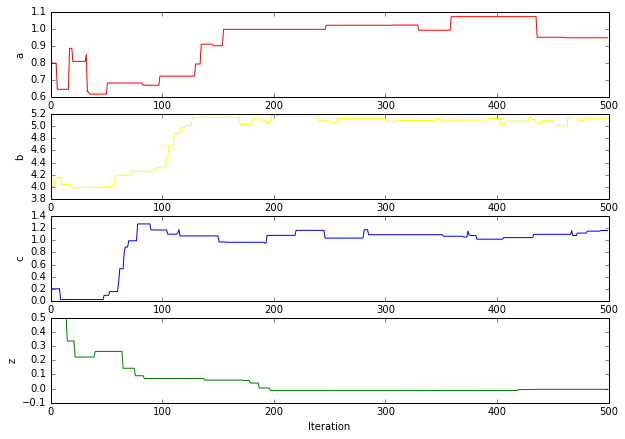

In [10]:
plt.figure(figsize=(10,7))              #adjust size of figure

plt.subplot(4, 1, 1)      
plt.plot(chain[:500,0],c='r')           #plot parameter a
plt.ylabel('a')                         #y-label

plt.subplot(4, 1, 2)
plt.plot(chain[:500,1],c='yellow')      #plot parameter b
plt.ylabel('b')                         #y-label

plt.subplot(4, 1, 3)
plt.plot(chain[:500,2],c='b')           #plot parameter c
plt.ylabel('c')                         #y-label

plt.subplot(4, 1, 4)
plt.plot(chain[:500,3],c='g')           #plot parameter z
plt.xlabel('Iteration')                 #x-label
plt.ylabel('z')                         #y-label

plt.show()

The initial values of used to initiate the MCMC routine were fairly far from their optimum spot, but after about 50-75 iterations, the value for each parameter settles towards the expected values of a=1,b=5,c=1.  This initial settling is known as **burn in**.  There are various techniques for identifying burning, including visual inspection.  For now lets clip out the first 200 chains.

In [11]:
chain=np.copy(chain[200:,:])   #cut first 100 chains

Let's look at the remaining distributions.

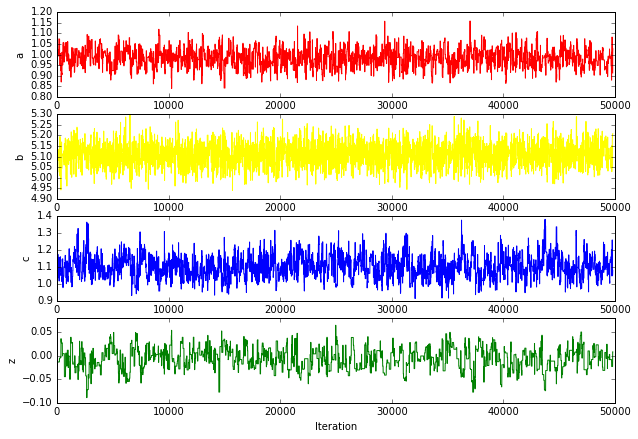

In [12]:
plt.figure(figsize=(10,7)) #adjust size of figure

plt.subplot(4, 1, 1)      
plt.plot(chain[:,0],c='r')  #plot parameter a
plt.ylabel('a')             #y-label

plt.subplot(4, 1, 2)
plt.plot(chain[:,1],c='yellow')   #plot parameter b
plt.ylabel('b')                   #y-label

plt.subplot(4, 1, 3)
plt.plot(chain[:,2],c='b')  #plot parameter c
plt.xlabel('Iteration')     #x-label
plt.ylabel('c')             #y-label

plt.subplot(4, 1, 4)
plt.plot(chain[:,3],c='g')  #plot parameter z
plt.xlabel('Iteration')     #x-label
plt.ylabel('z')             #y-label

plt.show()

Each element of a Markov-Chain is a self-consistent model.  Let's plot some of the chain elements on top of our data.

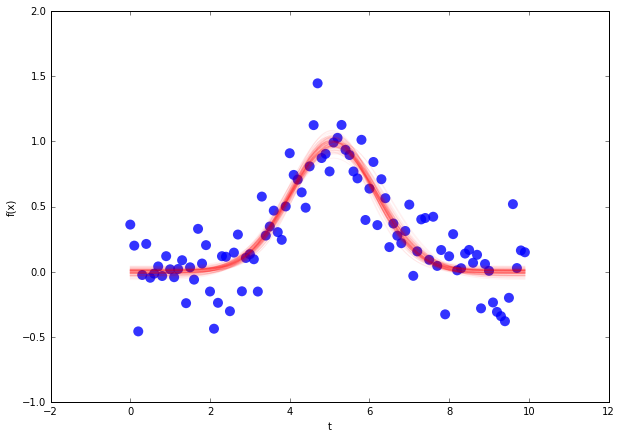

In [13]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
#plt.plot(t,g,c='red')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.8, edgecolors="none")  #plot our data
chainlen=len(chain[:,0])   #number of chains
for i in range(0,100):     #plot 100 random chain elements
    nchain=int(np.random.rand()*chainlen)  #randomly select a chain
    pars=chain[nchain,:]                   #select chain
    plotdata=gaussian(t,a=pars[0],b=pars[1],c=pars[2],z=pars[3]) #return model with chain element parameters
    plt.plot(t,plotdata,c='r', alpha=0.05)                       #plot the model.
plt.show()

## Means and Standard Deviation

In [14]:
label=['a','b','c','z'] 
gt=[a,b,c,z]
for i in range(0,len(chain[1,:])):
    mm=np.mean(chain[:,i])
    stdev=np.std(chain[:,i])
    print('%s %.3f %.3f' % (label[i], mm,stdev))

a 0.984 0.043
b 5.110 0.052
c 1.102 0.064
z -0.006 0.023


## Making a Triangle Plot

In [15]:
def triplot(chain,label,colour,nbin,ntick=5):
    "Making a Triangle Plot"

    nullfmt = NullFormatter()       # removing tick labels
    deffmt = ScalarFormatter()      # adding tick labels
    n=len(chain[1,:])               # determine number of subplots
    plt.figure(1, figsize=(10, 10))   # make a square figure
    wsize=0.9/n                     # size of individual panels

    prange=np.zeros(shape=(n,2))    #store range of parameters in chains 
    for i in range(0,n):
        prange[i,0]=min(chain[:,i]) #find minimum values
        prange[i,1]=max(chain[:,i]) #find maximum values

    for j in range(0,n):        #loop over each variable
        for i in range(j,n):    #loop again over each variable 
            left, width = 0.1+j*wsize, wsize        #determine panel size: left position and width
            bottom, height = 0.9-i*wsize, wsize     #determine panel size: bottom position and width
            rect_scatter = [left, bottom, width, height]#save panel size position    
            axScatter = plt.axes(rect_scatter)          #set panel size
        
            #put histogram on diagonals, scatter plot otherwise 
            if i == j:
                plt.hist(chain[:,j],nbin,histtype='stepfilled', facecolor=colour[i], alpha=0.8)
                x1,x2,y1,y2 = plt.axis() 
                plt.axis((prange[j,0],prange[j,1],y1,y2))
            else:
                axScatter.scatter(chain[:,j],chain[:,i],c="black", s=1.0, alpha=0.1, \
                 edgecolors="none")
                plt.axis((prange[j,0],prange[j,1],prange[i,0],prange[i,1]))   
            
            #to use a sensible x-tick range, we have to do it manually.
            dpr=(prange[j,1]-prange[j,0])/ntick         #make ntick ticks
            rr=np.power(10.0,np.floor(np.log10(dpr)))
            npr=np.floor(dpr/rr+0.5)*rr
            plt.xticks(np.arange(np.floor(prange[j,0]/rr)*rr+npr, \
             np.floor(prange[j,1]/rr)*rr,npr),rotation=30) #make ticks
        
            if i != j:    
                #use a sensible y-tick range, we have to do it manually
                dpr=(prange[i,1]-prange[i,0])/ntick         #make ntick ticks
                rr=np.power(10.0,np.floor(np.log10(dpr)))
                npr=np.floor(dpr/rr+0.5)*rr
                plt.yticks(np.arange(np.floor(prange[i,0]/rr)*rr+npr,\
                 np.floor(prange[i,1]/rr)*rr,npr),rotation=0) #make ticks
        
            axScatter.xaxis.set_major_formatter(nullfmt)  #default is to leave off tick mark labels
            axScatter.yaxis.set_major_formatter(nullfmt)
        
            #if we are on the sides, add tick and axes labels
            if i==n-1:
                axScatter.xaxis.set_major_formatter(deffmt)
                plt.xlabel(label[j]) 
            if j==0 :
                if i > 0:
                    axScatter.yaxis.set_major_formatter(deffmt)
                    plt.ylabel(label[i]) 


    plt.show()
    
    return;

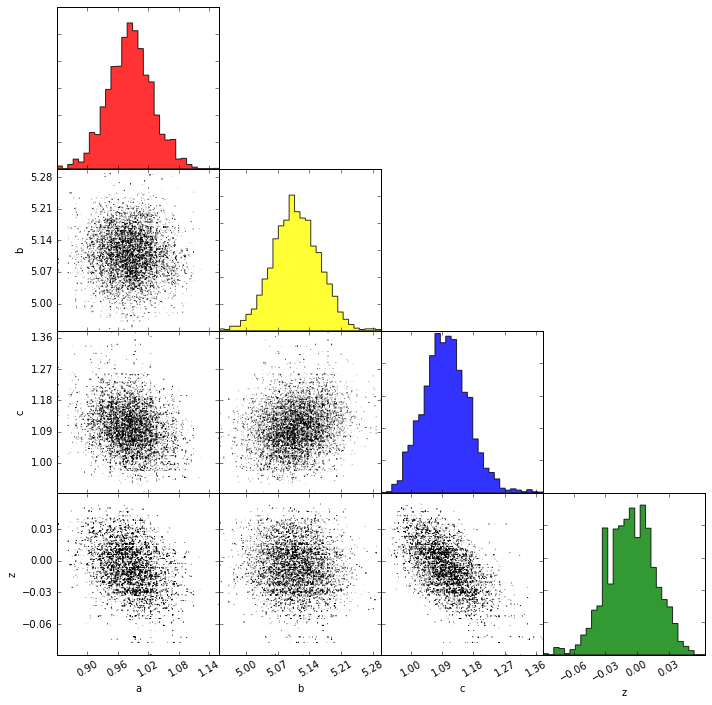

In [16]:
label=['a','b','c','z']        # Labels for the plots
colour=['r','yellow','b','g']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,label,colour,nbin)

# Assumptions

The biggest assumption we made in our analysis, was perfect knownledge of the measurement uncertainty $\sigma$.  We can lighten this restriction by allowing for a scale-factor to be fit 

In [17]:
x=[0.8,4.0,0.2,0.5,1.0]         #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]      #adding a scale factor for the errors 
niter=50000                     #number of iterations
chain,accept=genchain(x,beta,niter)
chain=np.copy(chain[200:,:])   #cut first 100 chains

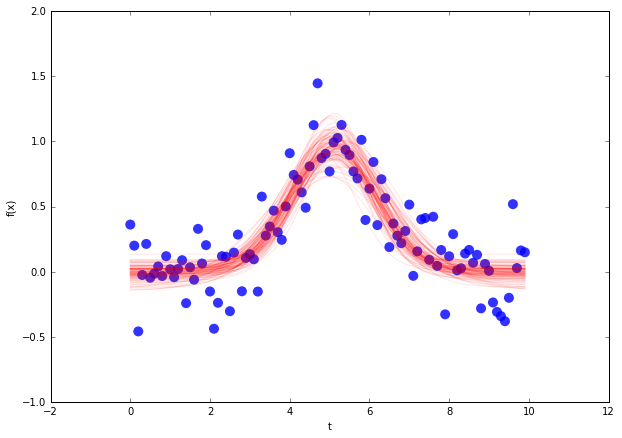

In [18]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
#plt.plot(t,g,c='red')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.8, edgecolors="none")  #plot our data
chainlen=len(chain[:,0])   #number of chains
for i in range(0,100):     #plot 100 random chain elements
    nchain=int(np.random.rand()*chainlen)  #randomly select a chain
    pars=chain[nchain,:]                   #select chain
    plotdata=gaussian(t,a=pars[0],b=pars[1],c=pars[2],z=pars[3]) #return model with chain element parameters
    plt.plot(t,plotdata,c='r', alpha=0.1)                       #plot the model.
plt.show()

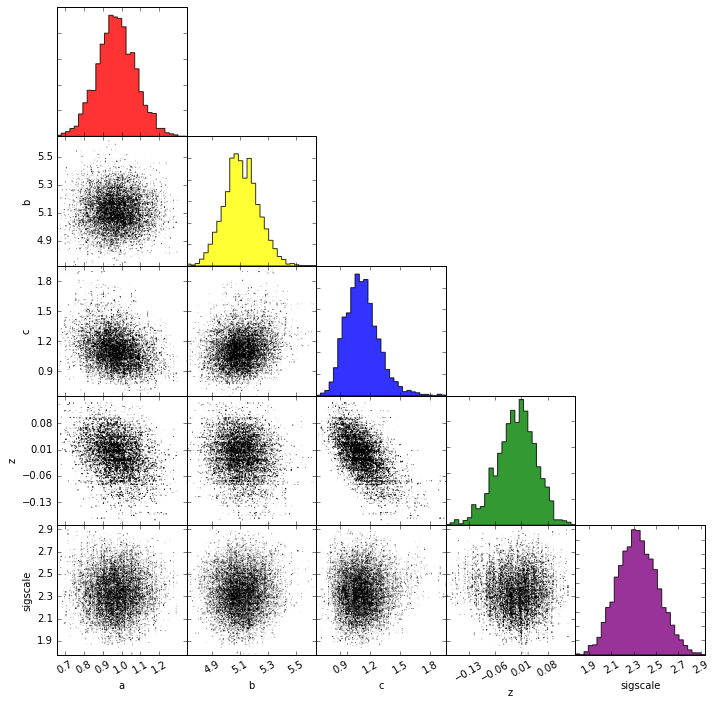

a 0.973 0.100
b 5.113 0.123
c 1.119 0.166
z -0.004 0.052
sigscale 2.336 0.180


In [19]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,label,colour,nbin,ntick=5)
for i in range(0,len(chain[1,:])):
    print('%s %.3f %.3f' % (label[i], np.mean(chain[:,i]),np.std(chain[:,i])))

## Confidence Intervals

The models prefer errors that are more than twice as large are we assumed.  All parameter are all within 1 standard deviation of the ground truth.  The chains can be used to estimate estimate confidence limits on our measurements, for example the 5th, 50th and 95th percentile: 

In [20]:
perc = np.percentile(chain[:,0],[5.0, 50.0, 95.0])
print('%s %.3f %.3f %.3f' % ('5th, 50th, 95th percentile for a:',perc[0],perc[1],perc[2]))

for i in range(0,len(chain[1,:])):
    perc = np.percentile(chain[:,i],[5.0, 50.0, 95.0])
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

5th, 50th, 95th percentile for a: 0.809 0.972 1.143
a = 0.972 +0.171 -0.163 (2 Sigma)
b = 5.108 +0.213 -0.194 (2 Sigma)
c = 1.108 +0.300 -0.230 (2 Sigma)
z = -0.000 +0.078 -0.096 (2 Sigma)
sigscale = 2.331 +0.313 -0.285 (2 Sigma)


Thus it is trivial to estimate and report non-Gaussian and assymetric probabilities.  

## Convergence

We have assumed that the MCMC results have converged and thus are giving us a realistic representation of the posterior, $p(x~|~d)$.  A common test is to use the Gelman-Rubin Convergence criteria, which compares in the between chains and within chain variance.  The test requires multiple, $M$, chains each of length, $N$.  Each parameter, $\theta$ in each chain, $m$, has a mean, $\hat{\theta}_m$, and variance ,$\hat{\sigma}_m^2$.  The overal posterior mean is given by,

$$ \hat{\theta} = \frac{1}{M} \sum_{m=1}^{M} \hat{\sigma}_m^2 $$

and the between chains variance,

$$ B = \frac{N}{M-1}\sum_{m=1}^{M}(\hat{\theta}_m - \hat{\theta})^2 $$

and the within chain variance,

$$ W = \frac{1}{M} \sum_{m=1}^{M} \hat{\sigma}^2_m $$

The gives the Pooled variance,

$$  \hat{V} = \frac{N-1}{N} W + \frac{M+1}{MN} B $$

Which allows to estimate the potential scale reduction factor (PSRF),

$$ Rc = \sqrt{\frac{\hat{d}+3}{\hat{d}+1} \frac{\hat{V}}{W} } $$

with $\hat{d}$ thr degrees of freedom of a t distribution. 

If $Rc$ is large, then your chains have not convergence.  One solution is to generate longer chain sets and test again.  If $Rc$ < 1.2 then your chains have likely converged.  A more stringent condition is when $Rc$ < 1.1.   


## Implement the Gelman-Rubin convergence test

In [21]:
def gelmanrubin(*chain,npt):
    "Estimating PSRF"
    M=len(chain)         #number of chains
    N=chain[0].shape[0] #assuming all chains have the same size.
    npars=chain[0].shape[1] #number of parameters
    pmean=np.zeros(shape=(M,npars)) #allocate array to hold mean calculations 
    pvar=np.zeros(shape=(M,npars))  #allocate array to hold variance calculations

    
    for i in range(0,M):
        currentchain=chain[i]
        for j in range(0,npars):
            pmean[i,j]=np.mean(currentchain[:,j]) #Generate means for each parameter in each chain
            pvar[i,j]=np.var(currentchain[:,j])   #Generate variance for each parameter in each chain
    
    posteriormean=np.zeros(npars) #allocate array for posterior means
    for j in range(0,npars):
        posteriormean[j]=np.mean(pmean[:,j]) #calculate posterior mean for each parameter
        
    #Calculate between chains variance
    B=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            B[j]+=np.power((pmean[i,j]-posteriormean[j]),2)
    B=B*N/(M-1.0)    
    
    #Calculate within chain variance
    W=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            W[j]+=pvar[i,j]
    W=W/M 
    
    
    #Calculate the pooled variance
    V=(N-1)*W/N + (M+1)*B/(M*N)
    
    dof=npt-1 #degrees of freedom 
    psrf=np.sqrt((dof+3.0)/(dof+1.0)*V/W) #PSRF from Brooks and Gelman (1997)
    
    return psrf;

We will generate 3 more chains.  Try changing niter to see how many chains are needed for convergence.

In [22]:
x=[0.8,4.0,0.2,0.5,1.0]                #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]             #adding a scale factor for the errors 
niter=1000                             #number of iterations
chain,accept=genchain(x,beta,niter)
chain=np.copy(chain[200:,:])           #cut first 200 chains
chain2,accept=genchain(x,beta,niter)
chain2=np.copy(chain[200:,:])          #cut first 200 chains
chain3,accept=genchain(x,beta,niter)
chain3=np.copy(chain[200:,:])          #cut first 200 chains

Calculate Rs for each parameter in our model

In [23]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,npt=npt)
print('Gelam-Rubin Convergence:')
for i in range(0,len(chain[1,:])):
    print('%s %.3f' %(label[i],grtest[i]))

Gelam-Rubin Convergence:
a 1.014
b 1.009
c 1.010
z 1.009
sigscale 1.034


## Acceptance Rates

The rate at which a trail state is accepted and rejected is an important consideration towards efficiently implementing MCMC and whether the results can be trusted.

If the acceptance rate is too low, then the value of $\beta$ for the Gibbs sampler is likely too large.   Many trails are being attemped that have a low probability.  In this scenerio the exploration of parameter space will be slow and large chain lengths will be required for convergence.

If the acceptance rate is too high, then the value of $\beta$ for the Gibbs sampler is likely too small.  Many trails are being attempted that are close by in parameter space.  In this scenerio, only the local parameter and probability space is explored. The true distributions correlated parameter probability will very slowly be explored and again, large chain lengths will be required for true convergence.

An acceptance rate should ideally be between 22 and 28% for each parameter.  

In [24]:
def calcacrate(accept):
    "Calculate Acceptance Rates"
    nchain=len(accept[:,0])
    print ('%s %.3f' % ('Global Acceptance Rate',(nchain-np.sum(accept[:,0]))/nchain))

    for j in range(0,len(chain[0,:])):
        nprop=0
        acrate=0
        for i in range(0,nchain):
            if accept[i,1] == j :
                nprop=nprop+1
                acrate=acrate+accept[i,0]
        print('%s Acceptance Rate %.3f' % (label[j],(nprop-acrate)/nprop))
    
    return;

In [25]:
calcacrate(accept)

Global Acceptance Rate 0.500
a Acceptance Rate 0.428
b Acceptance Rate 0.611
c Acceptance Rate 0.462
z Acceptance Rate 0.211
sigscale Acceptance Rate 0.781


None of our acceptance rates are in the ideal range.  We can either manually adjust $\beta$, or dynamically adjust $\beta$ using the prescription from Gregory 2001 by first estimating 

$$ acorsub = \frac{nacor - nacorsub}{npropP - npropPsub} $$

where,  
$nacor$ - total number of accepted proposals  
$nacorsub$ - total number of accepted proposals immediately prior to rescaling $\beta$  
$npropP$ - total number of proposals
$npropPsub$ - total number of proposals imediately prior to rescaling $\beta$  

We then define our rescaling parameter, $corscale$,

$$ corscale=corscale \times \left[ \frac{acorsub+\Delta}{0.25} \frac{0.75}{1-acorsub+\Delta}\right]^{1/4} $$

with $\Delta=0.01$. 

If the acceptance rate is 0.25 then corscale does not change.



In [26]:
def betarescale(x,beta,niter,burnin):
    "Calculate rescaling of beta to improve acceptance rates"
    
    delta=0.01
    
    npars=len(x)   #Number of parameters
    acorsub=np.zeros(npars) 
    nacor=np.zeros(npars)       #total number of accepted proposals
    nacorsub=np.zeros(npars)    #total number of accepted proposals immediately prior to rescaling
    npropp=np.zeros(npars)      #total number of proposals
    nproppsub=np.zeros(npars)   #total number of proposals immediately prior to rescaling
    acrate=np.zeros(npars)      #current acrate 
    corscale=np.ones(npars)
    
    #inital run
    chain,accept=genchain(x,beta,niter) #Get a MC   
    nchain=len(chain[:,0])
    for i in range(burnin,nchain):
        j=accept[i,1]
        npropp[j]+=1            #update total number of proposals
        nacor[j]+=1-accept[i,0] #update total number of accepted proposals
        
    #update x
    xin=chain[niter,:]
    
    acrate=nacor/npropp #inital acceptance rate
    afix=np.ones(npars)
    for i in range(0,npars):
        if acrate[i]<0.28 and acrate[i]>0.22:
            afix[i]=0

    imax=10
    icount=0
    while (np.sum(afix) > 0):
        icount+=1
        #Make another chain starting with xin
        nacorsub=np.zeros(npars) #reset nacorsub
        nproppsub=np.zeros(npars) #reset nproppsub
        betain=beta*corscale
        chain,accept=genchain(xin,betain,niter) #Get a MC
        xin=chain[niter,:]
        for i in range(burnin,nchain):
            j=accept[i,1]
            if acrate[j]>0.28 or acrate[j]<0.22:
                npropp[j]+=1            #update total number of proposals
                nacor[j]+=1-accept[i,0] #update total number of accepted proposals
                nproppsub[j]+=1            #Update current number of proposals
                nacorsub[j]+=1-accept[i,0] #Update current number of accepted proposals
    
        for i in range(0,npars):
            if afix[i]>0:
                #calcate current acrates
                acrate[i]=nacorsub[i]/nproppsub[i]
    
                #calcualte acorsub
                acorsub[i]=(nacor[i]-nacorsub[i])/(npropp[i]-nproppsub[i])
    
                #calculate corscale
                corscale[i]=corscale[i]*np.power((acorsub[i]+delta)*0.75/(0.25*(1.0-acorsub[i]+delta)) ,0.25)
    
        for i in range(0,npars):
            if acrate[i]<0.28 and acrate[i]>0.22:
                afix[i]=0

        if(icount>imax): 
            afix=np.zeros(npars)
    
    print('Final Acceptance: ',acrate)
    return corscale;

Get scaling parameters for better Beta values

In [27]:
x=[0.8,4.0,0.2,0.5,1.0]                #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]             #adding a scale factor for the errors 
niter=1000 
burnin=100
corscale=betarescale(x,beta,niter,burnin)
print("New beta scaling: ",corscale)

Final Acceptance:  [ 0.25980392  0.06285714  0.27218935  0.22151899  0.05851064]
New beta scaling:  [  2.02762645   7.9383983    3.50595824   0.90559512  54.92832396]


# Putting it all Together

1) Generate chains  
2) Examine Acceptance Rates  
3) Convergence Tests  
4) Examine Chains and Parameters  

In [28]:
x=[0.8,4.0,0.2,0.5,1.0]         #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]      #adding a scale factor for the errors 
betanew=beta*corscale #apply our new beta
niter=50000                     #number of iterations
chain,accept=genchain(x,betanew,niter)
chain=np.copy(chain[200:,:])   #cut first 100 chains
chain2,accept=genchain(x,beta,niter)
chain2=np.copy(chain[200:,:])          #cut first 200 chains
chain3,accept=genchain(x,beta,niter)
chain3=np.copy(chain[200:,:])          #cut first 200 chains

In [29]:
calcacrate(accept)

Global Acceptance Rate 0.494
a Acceptance Rate 0.402
b Acceptance Rate 0.553
c Acceptance Rate 0.500
z Acceptance Rate 0.202
sigscale Acceptance Rate 0.815


While not perfect, our acceptance rates are in a much better range.

In [30]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,npt=npt)
print('Gelam-Rubin Convergence:')
for i in range(0,len(chain[1,:])):
    print('%s %.3f' %(label[i],grtest[i]))

Gelam-Rubin Convergence:
a 1.010
b 1.010
c 1.010
z 1.010
sigscale 1.010


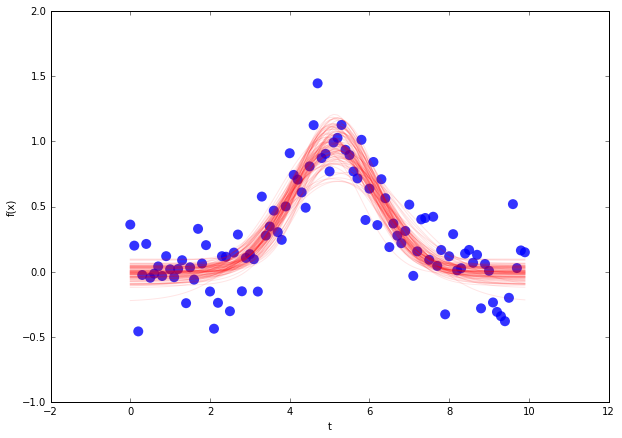

In [31]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
#plt.plot(t,g,c='red')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.8, edgecolors="none")  #plot our data
chainlen=len(chain[:,0])   #number of chains
for i in range(0,100):     #plot 100 random chain elements
    nchain=int(np.random.rand()*chainlen)  #randomly select a chain
    pars=chain[nchain,:]                   #select chain
    plotdata=gaussian(t,a=pars[0],b=pars[1],c=pars[2],z=pars[3]) #return model with chain element parameters
    plt.plot(t,plotdata,c='r', alpha=0.1)                       #plot the model.
plt.show()

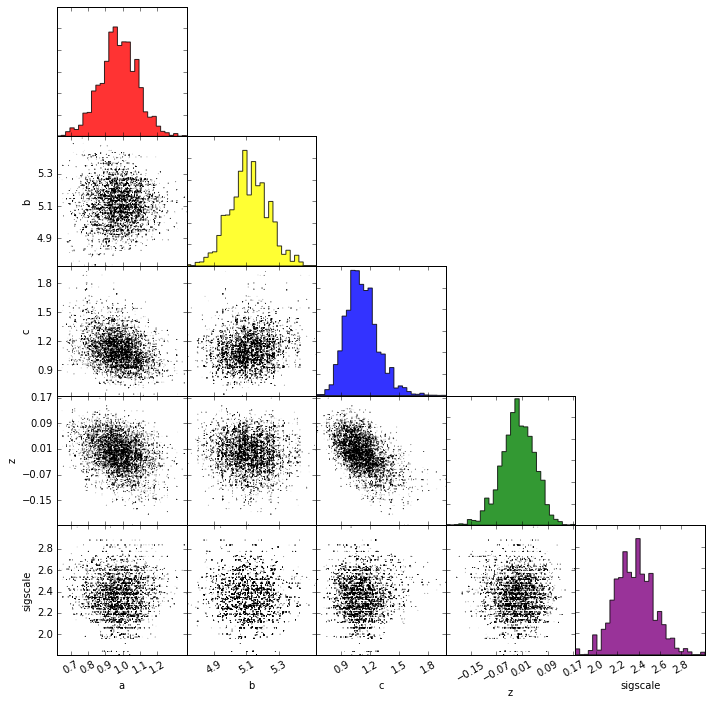

In [32]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,label,colour,nbin,ntick=5)

In [33]:
for i in range(0,len(chain[1,:])):
    perc = np.percentile(chain[:,i],[5.0, 50.0, 95.0])
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

a = 0.976 +0.177 -0.182 (2 Sigma)
b = 5.111 +0.196 -0.187 (2 Sigma)
c = 1.093 +0.320 -0.225 (2 Sigma)
z = -0.002 +0.082 -0.094 (2 Sigma)
sigscale = 2.355 +0.302 -0.290 (2 Sigma)


# Other Topics?

de-MCMC - methods for handling strongly correlated variables  
annealing - methods for more efficient exploration of parameter space  
nested sampling - forget MCMC, nested sampling is better (just ask the cosmologists)  